In [2]:
# 載入需要的套件
import os
import numpy as np 
import pandas as pd
import copy
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, Imputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

In [187]:
# 設定 data_path
dir_data = './data/'
Train = os.path.join(dir_data, 'train.csv')
Test = os.path.join(dir_data, 'test.csv')

# 讀取檔案
Train_data = pd.read_csv(Train)
Test_data = pd.read_csv(Test)

In [4]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    
def na_check2(df_data):
    #missing data
    total = df_data.isnull().sum().sort_values(ascending=False)
    percent = (df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    display(missing_data.head(4))
    
def area_type(row):
    if row >= 0:
        return 1
    else:
        return 0

In [188]:
#train_Y = np.log1p(Train_data['total_price'])
ids = Test_data['building_id']

tp = copy.deepcopy(np.log1p(Train_data['total_price']))

Train_data = Train_data.drop(['building_id'] , axis=1)
#Train_data = Train_data.drop(['building_id', 'total_price'] , axis=1)
Test_data = Test_data.drop(['building_id'] , axis=1)

df = pd.concat([Train_data,Test_data])

df.head()

,III_10,III_100,III_1000,III_10000,III_250,III_50,III_500,III_5000,III_MIN,III_index_1000,...,total_floor,total_price,town,town_area,town_population,town_population_density,txn_dt,txn_floor,village,village_income_median
0,0,3,91,3728,17,1,37,1861,42.635964,1,...,4,6.476038e+05,334,1.4161,24219.0,17103.0,18674,3.0,3132,572.0
1,1,1,29,7380,4,1,11,2512,7.157464,1,...,5,3.321452e+06,180,23.1373,551480.0,23835.0,18800,5.0,921,550.0
2,0,1,235,7971,17,0,73,2695,86.589412,1,...,4,9.570885e+06,180,23.1373,551480.0,23835.0,19289,1.0,1544,625.0
3,0,1,50,3904,3,1,5,2157,45.508654,1,...,24,1.421501e+07,343,14.7523,139259.0,9440.0,20385,13.0,3350,950.0
4,0,0,1,1449,0,0,0,134,546.047664,1,...,2,7.627120e+05,102,71.0400,112397.0,1582.0,20657,NaN,63,536.0


In [6]:
na_check(df)

,Missing Ratio
parking_area,94.852857
parking_price,76.821429
txn_floor,26.487143
village_income_median,1.894286


In [7]:
na_check2(df)

,Total,Percent
parking_area,66397,0.948529
parking_price,53775,0.768214
txn_floor,18541,0.264871
village_income_median,1326,0.018943


In [189]:
df = df.drop(['doc_rate', 'master_rate', 'jobschool_rate', 'highschool_rate'] , axis=1)
df = df.drop(['XIII_5000'] , axis=1)

In [190]:
df.sort_values(by = 'parking_price', ascending = False)[:2]
df = df.drop(55472)
df = df.drop(8795)
df = df.drop(37480)
df = df.drop(51731)

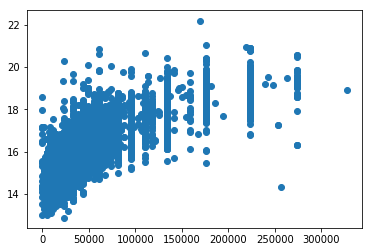

In [191]:
train_num = train_Y.shape[0]-4
train_Y = np.log1p(df[:train_num]['total_price'])
train_X = df[:train_num]

plt.scatter(train_X["parking_price"], train_Y)

In [192]:
df.sort_values(by = 'land_area', ascending = False)[:7]
df = df.drop(10670)
df = df.drop(41331)
df = df.drop(39191)
df = df.drop(53966)
df = df.drop(7814)
df = df.drop(13332)
df = df.drop(9785)
df = df.drop(14007)
df = df.drop(50076)
df = df.drop(2086)

In [193]:
train_num

59964

In [194]:
len(train_Y)

59964

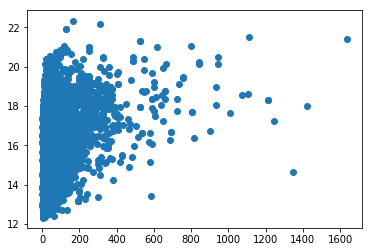

In [195]:
train_num = train_Y.shape[0]-10
train_Y = np.log1p(df[:train_num]['total_price'])
train_X = df[:train_num]

plt.scatter(train_X["land_area"], train_Y)

In [196]:
df.sort_values(by = 'building_area', ascending = False)[:20]
df = df.drop(9491)
df = df.drop(46934)
df = df.drop(50076)

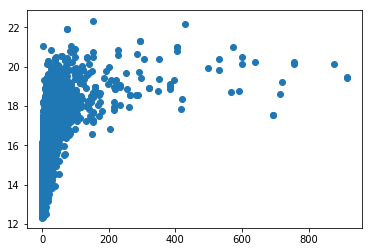

In [197]:
train_num = train_Y.shape[0]-1
train_Y = np.log1p(df[:train_num]['total_price'])
train_X = df[:train_num]

plt.scatter(train_X["building_area"], train_Y)

In [198]:
train_num

59953

In [199]:
len(train_Y)

59953

In [200]:
train_Y = np.log1p(df[:train_num]['total_price'])
df = df.drop(['total_price'] , axis=1)
df = df.drop(['parking_area'] , axis=1)

In [201]:
parking_price = df['parking_price']
#parking_area = df['parking_area']

df = df.drop(['parking_price'] , axis=1)
#df = df.drop(['parking_area'] , axis=1)

df = df.fillna(df.mean())
df['parking_price'] = parking_price

In [204]:
park_not_null = df[df['parking_price'].notnull()]
park_is_null = df[df['parking_price'].isnull()].drop(['parking_price'] , axis=1)

park_X = park_not_null.drop(['parking_price'] , axis=1)
park_Y = np.log1p(park_not_null['parking_price'])

In [205]:
XGB = xgb.XGBRegressor()
XGB.fit(park_X, park_Y)

park_pred = XGB.predict(park_is_null)
df.loc[df['parking_price'].notnull(), 'parking_price'] = np.log1p(park_not_null['parking_price'])
df.loc[df['parking_price'].isnull(), 'parking_price'] = park_pred

df.head()

[23:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,III_10,III_100,III_1000,III_10000,III_250,III_50,III_500,III_5000,III_MIN,III_index_1000,...,total_floor,town,town_area,town_population,town_population_density,txn_dt,txn_floor,village,village_income_median,parking_price
0,0,3,91,3728,17,1,37,1861,42.635964,1,...,4,334,1.4161,24219.0,17103.0,18674,3.000000,3132,572.0,5.705781
1,1,1,29,7380,4,1,11,2512,7.157464,1,...,5,180,23.1373,551480.0,23835.0,18800,5.000000,921,550.0,10.427354
2,0,1,235,7971,17,0,73,2695,86.589412,1,...,4,180,23.1373,551480.0,23835.0,19289,1.000000,1544,625.0,10.470032
3,0,1,50,3904,3,1,5,2157,45.508654,1,...,24,343,14.7523,139259.0,9440.0,20385,13.000000,3350,950.0,11.303930
4,0,0,1,1449,0,0,0,134,546.047664,1,...,2,102,71.0400,112397.0,1582.0,20657,5.393547,63,536.0,8.445126


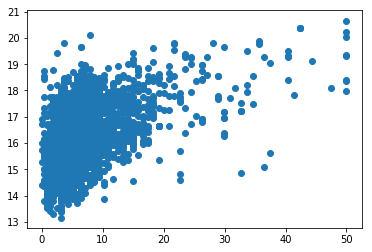

In [22]:
df['parking_area'] = parking_area
df.loc[:, "parking_area"] = df["parking_area"].clip(0.1, 50)

train_num = train_Y.shape[0]
train_X = df[:train_num]

plt.scatter(train_X["parking_area"], train_Y)

In [23]:
park_area_not_null = df[df['parking_area'].notnull()]
park_area_is_null = df[df['parking_area'].isnull()].drop(['parking_area'] , axis=1)

park_area_X = park_area_not_null.drop(['parking_area'] , axis=1)
park_area_Y = park_area_not_null['parking_area']

In [24]:
XGBR = xgb.XGBRegressor()
XGBR.fit(park_area_X, park_area_Y)

park_area_pred = XGBR.predict(park_area_is_null)

df.loc[df['parking_area'].isnull(), 'parking_area'] = park_area_pred

df.head()

[18:07:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,txn_floor,land_area,...,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,parking_price,parking_area
0,8,21,18674,4,3,2,6271,2,3.000000,18.144460,...,1,157,1,2483,1,6011,1,34.469803,5.480033,4.197453
1,8,7,18800,5,1,2,7885,2,5.000000,11.387227,...,1,115,1,15872,1,32221,1,40.073573,10.412824,2.721138
2,8,7,19289,4,1,2,6028,2,1.000000,21.426802,...,1,212,1,15760,1,32228,1,54.462081,10.463612,2.302792
3,8,21,20385,24,0,2,18325,0,13.000000,11.387227,...,1,125,1,2568,1,7271,1,99.628966,11.303930,6.734877
4,1,21,20657,2,4,2,6880,2,5.393906,61.306524,...,1,47,1,2587,1,7442,1,124.131236,8.313252,0.088575


In [208]:
len(train_Y)

59953

In [185]:
df.shape

(69979, 227)

In [144]:
temp_df = copy.deepcopy(df)

In [145]:
temp_df = temp_df.fillna(temp_df.mean())

temp_df["txn_dt"] = temp_df["txn_dt"]/100
temp_df["building_complete_dt"] = temp_df["building_complete_dt"]/100

temp_df["village_income_median"] = np.log1p(temp_df["village_income_median"])
#temp_df["building_area"] = temp_df["building_area"].clip(1, 50)
#temp_df["land_area"] = temp_df["land_area"].clip(1, 50)
temp_df["town_area"] = temp_df["town_area"].clip(1, 150)

temp_df["per_building_area"] = temp_df["building_area"] / temp_df["total_floor"]
temp_df["total_income"] = np.log1p(temp_df["village_income_median"] * temp_df["town_population"])
temp_df["area_percent"] = temp_df["land_area"] / temp_df["town_area"]
#temp_df["per_parking_price"] = np.log1p(np.expm1(temp_df["parking_price"]) / temp_df["parking_area"])
#temp_df["education_rate"] = temp_df["jobschool_rate"] + temp_df["highschool_rate"]

temp_df["area_diff"] = temp_df["land_area"] - temp_df["building_area"]
temp_df['area_type'] = temp_df['area_diff'].apply(area_type)
#temp_df = temp_df.drop(['area_diff'] , axis=1)

train_num = train_Y.shape[0]
train_X = temp_df[:train_num]
test_X = temp_df[train_num:]

In [146]:
temp_df["city"] = temp_df["city"].astype("str")
temp_df["town"] = temp_df["town"].astype("str")
temp_df["village"] = temp_df["village"].astype("str")
temp_df["city_town_village"] = temp_df["city"]+"_"+temp_df["town"]+"_"+temp_df["village"]

In [147]:
temp_df = temp_df.drop(['city'] , axis=1)
temp_df = temp_df.drop(['town'] , axis=1)
temp_df = temp_df.drop(['village'] , axis=1)

In [148]:
data = pd.concat([temp_df[:train_num], train_Y], axis=1)
test_data = temp_df[train_num:]

temp_df["txn_floor"] = temp_df["txn_floor"].astype('int')

cols = ["city_town_village", "building_type", "building_use", "total_floor", "txn_floor"]

for c in cols:
    
    mean_df = data.groupby([c])['total_price'].mean().reset_index()
    mean_df.columns = [c, f'{c}_mean']
    
    data = pd.merge(data, mean_df, on= c, how='left')
    data = data.drop([c] , axis=1)
    
    test_data = pd.merge(test_data, mean_df, on= c, how='left')   
    test_data = test_data.drop([c] , axis=1)
    
data = data.drop(['total_price'] , axis=1)

In [149]:
temp_df = pd.concat([data,test_data])
temp_df.head()

,III_10,III_100,III_1000,III_10000,III_250,III_50,III_500,III_5000,III_MIN,III_index_1000,...,per_building_area,total_income,area_percent,area_diff,area_type,city_town_village_mean,building_type_mean,building_use_mean,total_floor_mean,txn_floor_mean
0,0,3,91,3728,17,1,37,1861,42.635964,1,...,0.854544,11.943494,12.812980,14.726285,1,13.381036,15.617918,15.495359,15.607961,15.427127
1,1,1,29,7380,4,1,11,2512,7.157464,1,...,0.808262,15.062772,0.492159,7.345919,1,15.179834,15.368609,15.495359,15.397805,15.359153
2,0,1,235,7971,17,0,73,2695,86.589412,1,...,1.396070,15.082789,0.926072,15.842523,1,15.933452,15.368609,15.495359,15.607961,15.785717
3,0,1,50,3904,3,1,5,2157,45.508654,1,...,0.565126,13.769437,0.771895,-2.175803,0,15.649977,15.837282,15.495359,16.127585,15.832799
4,0,0,1,1449,0,0,0,134,546.047664,1,...,2.344054,13.468119,0.862986,56.618416,1,14.210887,15.428393,15.495359,14.954508,15.428393


In [150]:
train_X = temp_df[:train_num]

estimator = xgb.XGBRegressor()
estimator.fit(train_X, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=temp_df.columns)
feats = feats.sort_values(ascending=False)

[23:06:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [151]:
temp_df = temp_df.fillna(temp_df.mean())
train_X = temp_df[:train_num]

est = RandomForestRegressor()
est.fit(train_X, train_Y)
feats_est = pd.Series(data=est.feature_importances_, index=temp_df.columns)
feats_est = feats_est.sort_values(ascending=False)

In [170]:
temp_df.shape

(69991, 230)

In [166]:
high_feature = list(set(feats[feats!=0].index)&set(feats_est[feats_est!=0].index))

train_X = temp_df[:train_num][high_feature]
test_X = temp_df[train_num:][high_feature]

In [154]:
# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.25, random_state=4)

estimator_ = RandomForestRegressor()
estimator_.fit(x_train, y_train)

print(cross_val_score(estimator_, x_train, y_train, cv=5).mean())

y_pred = estimator_.predict(x_test)
print("Mean squared error: %.4f"
      % mean_squared_error(y_test, y_pred))

0.9414449757279438
Mean squared error: 0.0763


In [157]:
train_X.shape

(59983, 79)

In [167]:
test_X.shape

(10008, 79)

In [164]:
test_X = test_X[10:]

In [168]:
test_X

,txn_dt,land_area,VIII_100,V_10000,XIII_500,VII_250,XII_5000,building_type_mean,town_population,per_building_area,...,city_town_village_mean,VII_1000,VIII_250,X_5000,XI_10000,XIV_100,death_rate,V_1000,VI_MIN,III_5000
0,200.81,16.482126,9,5002,33,60,2307,15.617918,288295.0,1.068615,...,17.214858,477,48,475,3366,3,6.53,108,194.521556,1195
1,199.08,14.803422,1,7882,8,14,14604,15.368609,222585.0,0.981730,...,16.194802,314,5,1795,4702,0,5.93,71,516.884049,4714
2,181.94,11.387227,2,534,0,5,612,15.617918,97329.0,0.930848,...,14.835181,65,5,127,679,0,7.72,25,567.628326,247
3,187.15,16.482126,21,4016,27,57,3911,15.368609,287771.0,1.063594,...,16.034835,263,65,624,2750,0,6.53,66,406.786348,1334
4,183.59,21.426802,8,7407,4,49,13094,15.368609,551480.0,1.227162,...,16.077986,387,53,1422,4201,3,5.93,121,555.638816,3701
5,190.40,50.917365,0,383,0,8,1150,15.428393,200452.0,3.377030,...,13.917582,68,8,176,223,0,10.40,14,766.232392,511
6,197.06,4.181031,27,7813,16,127,13618,14.674654,230710.0,0.382628,...,16.388266,1149,87,1926,5154,7,6.53,232,113.702928,4754
7,199.01,11.387227,2,7321,2,20,13093,15.837282,551480.0,0.747604,...,15.889464,560,24,1403,4170,1,5.93,192,551.051652,3733
8,199.75,23.049441,2,7340,8,22,11327,15.368609,288295.0,1.745657,...,16.487045,312,10,1618,4780,4,6.53,71,370.187481,3906
9,203.85,16.482126,1,6826,3,25,11748,15.368609,551480.0,1.071358,...,16.088193,613,18,1310,3831,2,5.93,210,345.791587,3162


In [162]:
estimator_ = RandomForestRegressor(random_state=7)
estimator_.fit(train_X, train_Y)

predict = estimator_.predict(test_X)

test_price = np.expm1(predict)

submit = pd.DataFrame(ids)
submit['total_price'] = test_price
submit.to_csv("2019-06-26.csv",index=False)

ValueError: Length of values does not match length of index

In [ ]:
test_X